---
## 2019313550 박병현 5th Assignment
### Multi-class Image Classification on the SKKU Aircraft dataset

#### 1. SKKU Aircraft Dataset (Multi-classes)
This dataset is constructed based on the below reference dataset [1]. It consists of 5900 images in 10 classes. There are 3934 training images and 1966 test images. Here are the classes in the dataset.

#### 2. Multi-class Image Classification
Given the above SKKU aircraft dataset, build your deep learning model that predicts the aircraft manufacturer given an image. There are a total of 10 aircraft manufacturers in the dataset and each image has only one aircraft that belongs to one of 10 manufacturers.

#### References
[1] Fine-Grained Visual Classification of Aircraft, S. Maji, J. Kannala, E. Rahtu, M. Blaschko, A. Vedaldi, arXiv.org, 2013

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/인공지능/SKKU_MultiCls.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [18]:
base_dir = '/tmp'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [16]:
train_plane_fnames = os.listdir(train_dir)
print(train_plane_fnames[:10])

train_no_plane_fnames = os.listdir(test_dir)
train_no_plane_fnames.sort()
print(train_no_plane_fnames[:10])

['Airbus', 'Lockheed_Martin', 'Yakovlev', 'McDonnell_Douglas', 'Robin', 'Eurofighter', 'Saab', 'Canadair', 'Boeing', 'Embraer']
['Airbus', 'Boeing', 'Canadair', 'Embraer', 'Eurofighter', 'Lockheed_Martin', 'McDonnell_Douglas', 'Robin', 'Saab', 'Yakovlev']


In [29]:
# Directories
train_dir = '/tmp/train'
test_dir = '/tmp/test'

def count_files_in_directory(directory):
    sub_dirs = os.listdir(directory)
    file_counts = {}
    total_files = 0

    for sub_dir in sub_dirs:
        sub_dir_path = os.path.join(directory, sub_dir)
        if os.path.isdir(sub_dir_path):
            files = os.listdir(sub_dir_path)
            file_count = len(files)
            file_counts[sub_dir] = file_count
            total_files += file_count

    return file_counts, total_files

# Count files in train directory
train_file_counts, total_train_files = count_files_in_directory(train_dir)
print("Train directory:")
print('training planes classes:', len(os.listdir(train_dir)))
for sub_dir, count in train_file_counts.items():
    print(f"Number of images in {sub_dir}: {count}")
print(f"Total number of images in train directory: {total_train_files}")

# Count files in test directory
test_file_counts, total_test_files = count_files_in_directory(test_dir)
print("\nTest directory:")
print('total test planes classes:', len(os.listdir(test_dir)))
for sub_dir, count in test_file_counts.items():
    print(f"Number of images in {sub_dir}: {count}")
print(f"Total number of images in test directory: {total_test_files}")

print(f"\nTotal number of images: {total_test_files+total_train_files}")

Train directory:
training planes classes: 10
Number of images in Airbus: 867
Number of images in Lockheed_Martin: 67
Number of images in Yakovlev: 67
Number of images in McDonnell_Douglas: 467
Number of images in Robin: 66
Number of images in Eurofighter: 66
Number of images in Saab: 134
Number of images in Canadair: 267
Number of images in Boeing: 1466
Number of images in Embraer: 467
Total number of images in train directory: 3934

Test directory:
total test planes classes: 10
Number of images in Airbus: 433
Number of images in Lockheed_Martin: 33
Number of images in Yakovlev: 33
Number of images in McDonnell_Douglas: 233
Number of images in Robin: 34
Number of images in Eurofighter: 34
Number of images in Saab: 66
Number of images in Canadair: 133
Number of images in Boeing: 734
Number of images in Embraer: 233
Total number of images in test directory: 1966

Total number of images: 5900


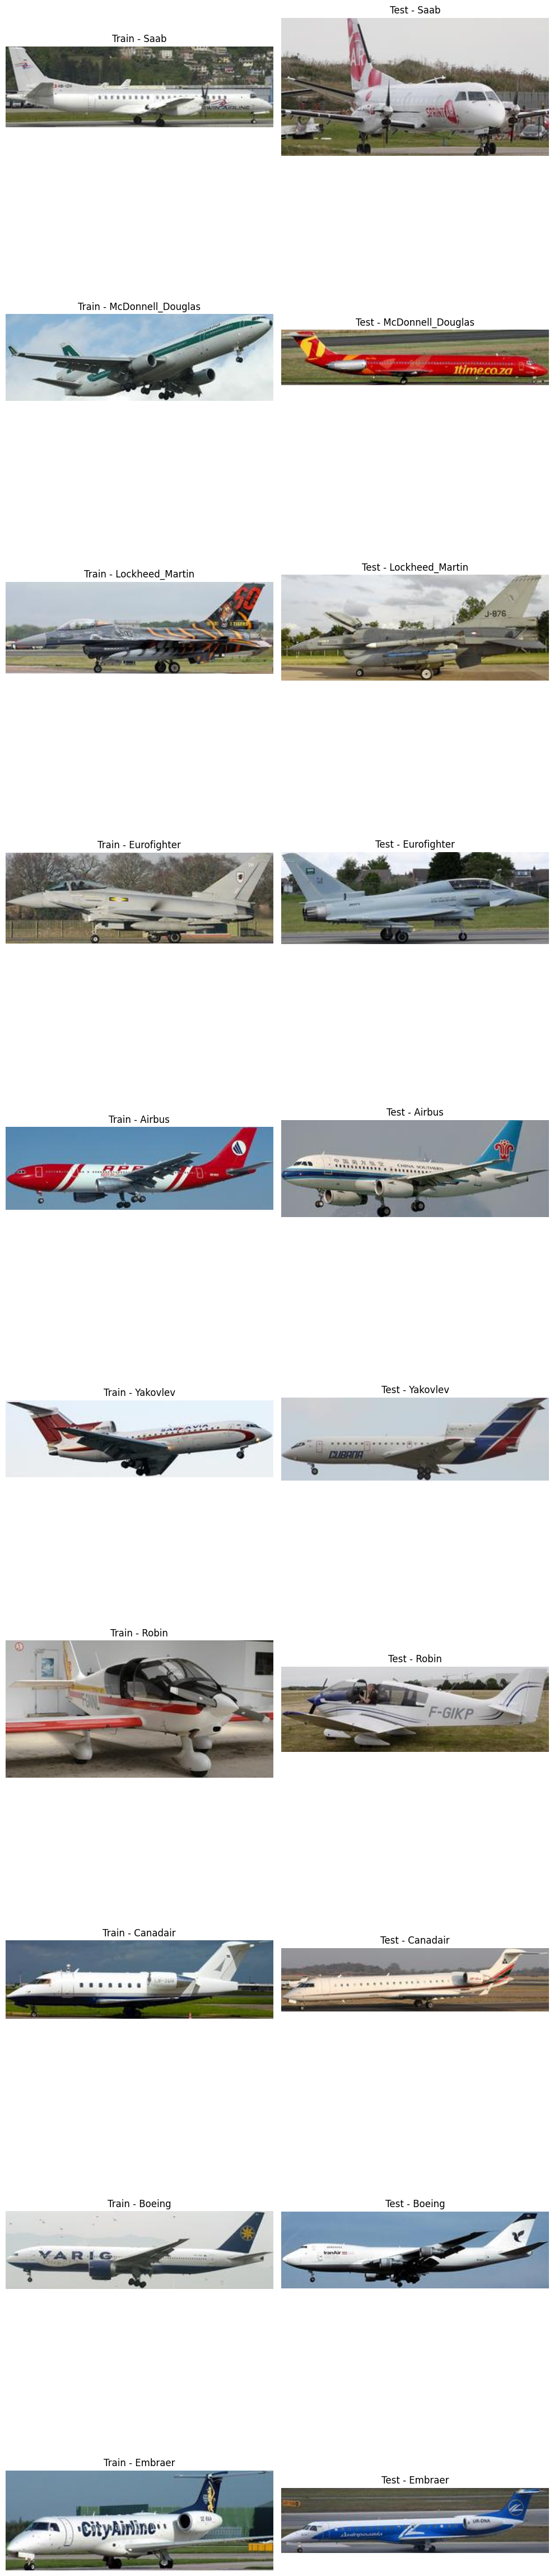

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directories
train_dir = '/tmp/train'
test_dir = '/tmp/test'

def get_sample_image_paths(directory):
    sample_image_paths = {}
    sub_dirs = os.listdir(directory)

    for sub_dir in sub_dirs:
        sub_dir_path = os.path.join(directory, sub_dir)
        if os.path.isdir(sub_dir_path):
            files = os.listdir(sub_dir_path)
            if files:
                sample_image_paths[sub_dir] = os.path.join(sub_dir_path, files[0])

    return sample_image_paths

# Get sample image paths
train_sample_images = get_sample_image_paths(train_dir)
test_sample_images = get_sample_image_paths(test_dir)

# Get common categories in train and test
common_categories = set(train_sample_images.keys()).intersection(set(test_sample_images.keys()))

# Plot the images side by side
fig, axes = plt.subplots(len(common_categories), 2, figsize=(10, len(common_categories) * 5))

for i, category in enumerate(common_categories):
    train_img_path = train_sample_images[category]
    test_img_path = test_sample_images[category]

    train_img = mpimg.imread(train_img_path)
    test_img = mpimg.imread(test_img_path)

    # Train image
    axes[i, 0].imshow(train_img)
    axes[i, 0].set_title(f"Train - {category}")
    axes[i, 0].axis('off')

    # Test image
    axes[i, 1].imshow(test_img)
    axes[i, 1].set_title(f"Test - {category}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

#### Loading the dataset using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

In [35]:
import tensorflow as tf
from tensorflow import keras

################################
batch_size = 32
num_of_train_imgs = 3934
num_of_test_imgs = 1966
img_height = 150
img_width = 150

################################

# Train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=num_of_train_imgs)

# Validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=num_of_train_imgs)

# Test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=num_of_test_imgs)

Found 3934 files belonging to 10 classes.
Using 3148 files for training.
Found 3934 files belonging to 10 classes.
Using 786 files for validation.
Found 1966 files belonging to 10 classes.


In [36]:
class_names = train_ds.class_names
print(class_names)

['Airbus', 'Boeing', 'Canadair', 'Embraer', 'Eurofighter', 'Lockheed_Martin', 'McDonnell_Douglas', 'Robin', 'Saab', 'Yakovlev']


## 1. Baseline - A Simple CNN model

Our simple CNN model that we used in the previous week!

In [42]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Assuming we have 10 classes for the output layer with softmax activation
output = layers.Dense(10, activation='softmax')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully connected layer + softmax output layer
model = Model(img_input, output)

In [43]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1849

In [44]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])


In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=16,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# Flow test images in batches of 20 using val_datagen generator
test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

history = model.fit(
      train_generator,
      epochs=15,
      validation_data=test_generator)

Found 3934 images belonging to 10 classes.
Found 1966 images belonging to 10 classes.
Epoch 1/15
246/246 [==============================] - 7s 23ms/step - loss: 1.7733 - acc: 0.3927 - val_loss: 1.3217 - val_acc: 0.5056
Epoch 2/15
246/246 [==============================] - 7s 28ms/step - loss: 1.1149 - acc: 0.5801 - val_loss: 0.9748 - val_acc: 0.6368
Epoch 3/15
246/246 [==============================] - 6s 26ms/step - loss: 0.6380 - acc: 0.7666 - val_loss: 0.9598 - val_acc: 0.6617
Epoch 4/15
246/246 [==============================] - 6s 26ms/step - loss: 0.3034 - acc: 0.8846 - val_loss: 0.9243 - val_acc: 0.7080
Epoch 5/15
246/246 [==============================] - 7s 28ms/step - loss: 0.1363 - acc: 0.9471 - val_loss: 1.1952 - val_acc: 0.6948
Epoch 6/15
246/246 [==============================] - 6s 26ms/step - loss: 0.0696 - acc: 0.9761 - val_loss: 1.3459 - val_acc: 0.7019
Epoch 7/15
246/246 [==============================] - 7s 28ms/step - loss: 0.0317 - acc: 0.9896 - val_loss: 1.6551 -

Text(0.5, 1.0, 'Training and validation loss')

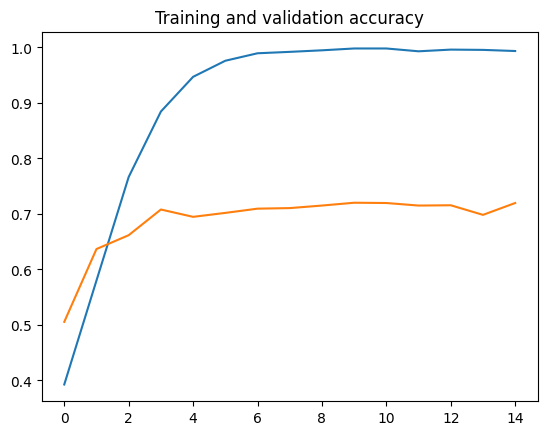

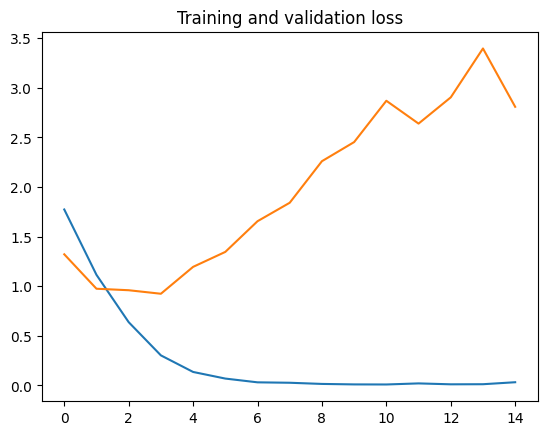

In [46]:
%matplotlib inline

import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of loss results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## 2. ResNet

To avoid gradient vanishing or exploding problems!

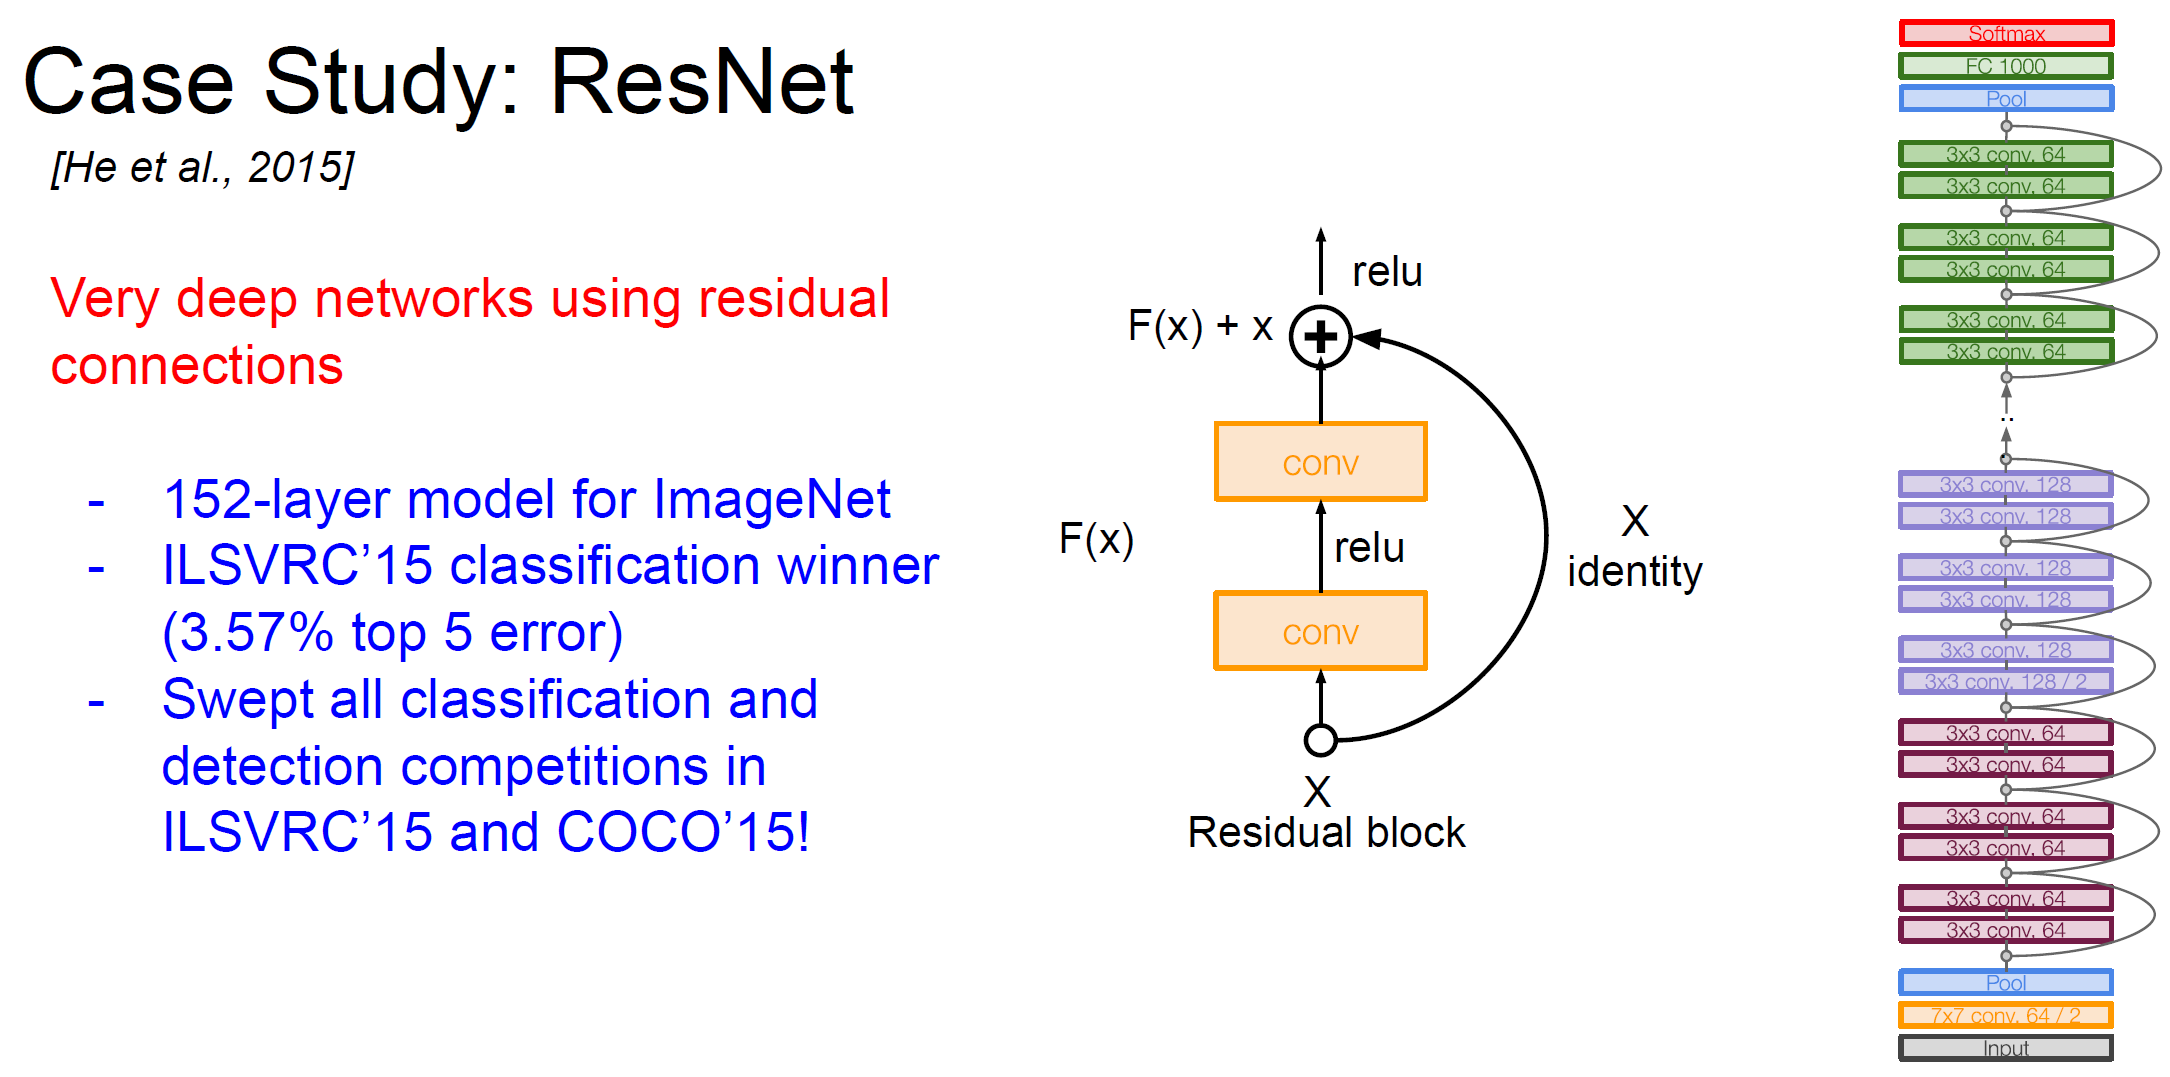

In [62]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define the number of classes
num_classes = 10  # Adjust this according to your dataset

# Load the ResNet50 model pre-trained on ImageNet, without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(150, 150, 3)))

# Add a global average pooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Create output layer with the number of classes and softmax activation
output = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Print model summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_6[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [63]:

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [64]:

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=16,
        class_mode='categorical')  # Use 'categorical' for multiclass classification

# Flow test images in batches of 20 using val_datagen generator
test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

# Train the model
history = model.fit(
      train_generator,
      epochs=15,
      validation_data=test_generator)


Found 3934 images belonging to 10 classes.
Found 1966 images belonging to 10 classes.
Epoch 1/15
246/246 [==============================] - 54s 135ms/step - loss: 1.7701 - acc: 0.3762 - val_loss: 1.8808 - val_acc: 0.3733
Epoch 2/15
246/246 [==============================] - 32s 129ms/step - loss: 1.1968 - acc: 0.4969 - val_loss: 1.9384 - val_acc: 0.1185
Epoch 3/15
246/246 [==============================] - 31s 125ms/step - loss: 0.8930 - acc: 0.6319 - val_loss: 1.7799 - val_acc: 0.2645
Epoch 4/15
246/246 [==============================] - 31s 125ms/step - loss: 0.6692 - acc: 0.7288 - val_loss: 4.3310 - val_acc: 0.2670
Epoch 5/15
246/246 [==============================] - 32s 129ms/step - loss: 0.5176 - acc: 0.7964 - val_loss: 1.2199 - val_acc: 0.6226
Epoch 6/15
246/246 [==============================] - 30s 124ms/step - loss: 0.4054 - acc: 0.8449 - val_loss: 4.3325 - val_acc: 0.4649
Epoch 7/15
246/246 [==============================] - 31s 124ms/step - loss: 0.3107 - acc: 0.8887 - val_

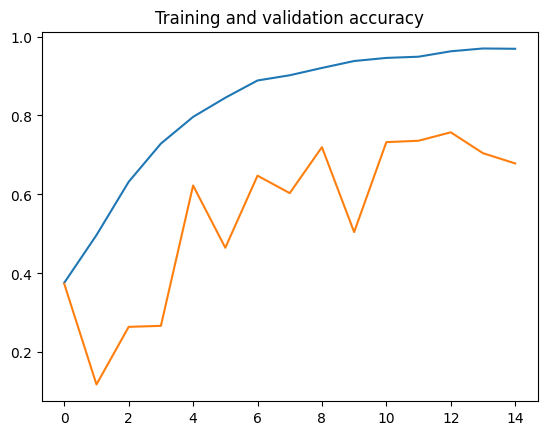

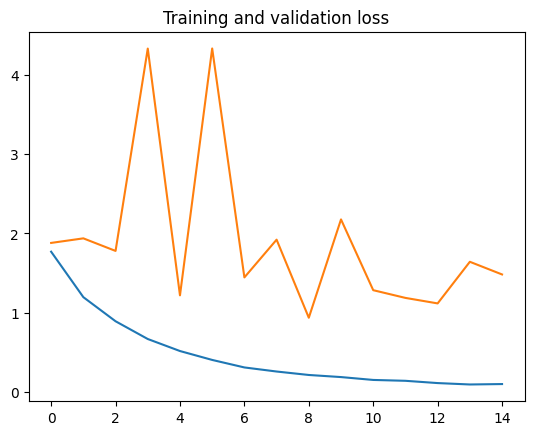

In [65]:
# Plotting the results
%matplotlib inline

# Retrieve a list of accuracy results on training and validation data sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of loss results on training and validation data sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

plt.show()


In [66]:
# do fun things!